In [ ]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base = Path("../results")

domains = ["cv", "nlp"]
models = ["claude", "gpt-4o"]
modes = ["title-abstract", "title-only"]

def load_all():
    rows = []
    for domain in domains:
        for model in models:
            for mode in modes:
                fname = f"{mode}_{model}_content.json"
                path = base / domain / fname
                with open(path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                for d in data:
                    for opt in ['A', 'B', 'C']:
                        rows.append({
                            'domain': domain,
                            'model': model,
                            'mode': mode,
                            'id': d['id'],
                            'option': opt,
                            'clarity': d['scores'][opt]['clarity'],
                            'originality': d['scores'][opt]['originality'],
                            'significance': d['scores'][opt]['significance'],
                            'chosen': (d['choice'] == opt)
                        })
    return pd.DataFrame(rows)

df_all = load_all()

df_all.head()

,domain,model,mode,id,option,clarity,originality,significance,chosen
0,cv,claude,title-abstract,1,A,5,4,5,True
1,cv,claude,title-abstract,1,B,3,2,3,False
2,cv,claude,title-abstract,1,C,2,3,2,False
3,cv,claude,title-abstract,2,A,5,4,5,True
4,cv,claude,title-abstract,2,B,4,2,3,False


In [ ]:
len(df_all)

df_all['domain'].value_counts()
df_all['model'].value_counts()
df_all['mode'].value_counts()

df_all.sample(10)


,domain,model,mode,id,option,clarity,originality,significance,chosen
603,nlp,claude,title-abstract,2,A,5,4,5,True
354,cv,gpt-4o,title-abstract,19,A,5,5,5,True
538,cv,gpt-4o,title-only,30,B,5,2,3,False
903,nlp,gpt-4o,title-abstract,2,A,5,5,5,True
225,cv,claude,title-only,26,A,4,3,3,True
29,cv,claude,title-abstract,10,C,3,3,4,False
1129,nlp,gpt-4o,title-only,27,B,4,2,3,False
308,cv,gpt-4o,title-abstract,3,C,3,4,3,False
700,nlp,claude,title-abstract,34,B,3,1,2,False
701,nlp,claude,title-abstract,34,C,3,2,3,False


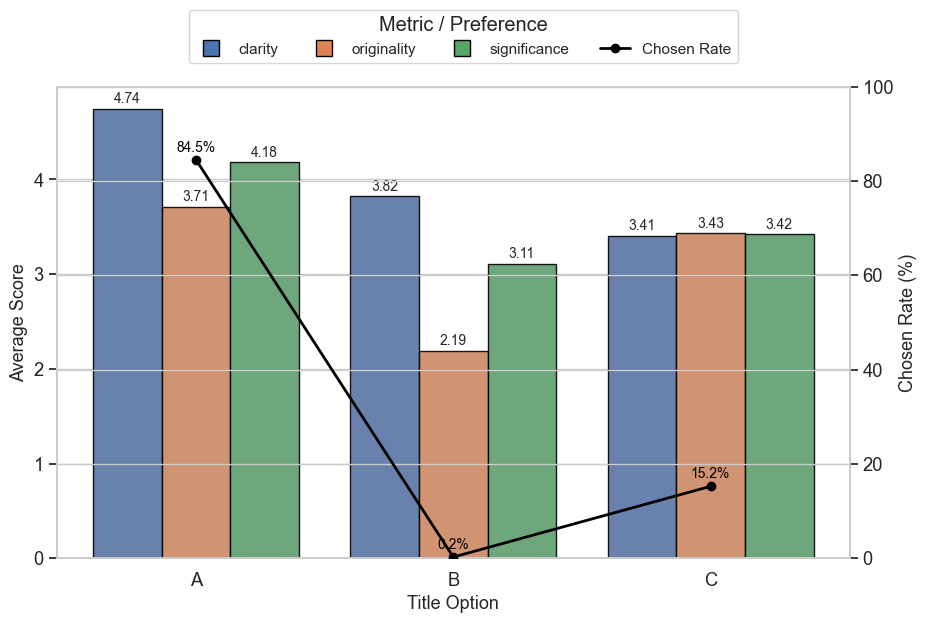

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

avg_scores = (
    df_all.groupby('option')[['clarity','originality','significance']]
    .mean()
    .reset_index()
    .melt(id_vars='option', var_name='metric', value_name='score')
)

chosen_rate = (
    df_all.groupby('option')['chosen']
    .mean()
    .reset_index()
    .rename(columns={'chosen':'chosen_rate'})
)

order = ['A','B','C']
avg_scores['option'] = pd.Categorical(avg_scores['option'], categories=order, ordered=True)
chosen_rate['option'] = pd.Categorical(chosen_rate['option'], categories=order, ordered=True)

sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {
    'clarity':'#4C72B0',
    'originality':'#DD8452',
    'significance':'#55A868'
}

fig, ax1 = plt.subplots(figsize=(9.5,6.2))

bar_ax = sns.barplot(
    data=avg_scores, x='option', y='score', hue='metric',
    palette=palette, alpha=0.9, edgecolor='black', ax=ax1
)

ax2 = ax1.twinx()
line, = ax2.plot(
    chosen_rate['option'], chosen_rate['chosen_rate']*100,
    color='black', marker='o', linewidth=2, label='Chosen Rate', zorder=5
)

ax1.set_ylabel("Average Score", fontsize=13)
ax2.set_ylabel("Chosen Rate (%)", fontsize=13)
ax1.set_xlabel("Title Option", fontsize=13)
ax2.set_ylim(0, 100)

# Numeric Labels (Bar)
for c in ax1.containers:
    ax1.bar_label(c, fmt='%.2f', label_type='edge', fontsize=10, padding=2)
# Numeric Labels (Line Chart)
for x, y in zip(chosen_rate['option'], chosen_rate['chosen_rate']*100):
    ax2.annotate(f"{y:.1f}%", xy=(x, y), xytext=(0,6),
                 textcoords='offset points', ha='center', fontsize=10, color='black')

if ax1.get_legend() is not None:
    ax1.get_legend().remove()

bar_handles, bar_labels = [], []
for m, color in palette.items():
    bar_handles.append(plt.Line2D([0],[0], marker='s', linestyle='',
                                  markersize=12, markerfacecolor=color,
                                  markeredgecolor='black', label=m))
    bar_labels.append(m)

line_handle = plt.Line2D([0],[0], color='black', marker='o', linewidth=2, label='Chosen Rate')

handles = bar_handles + [line_handle]
labels  = bar_labels  + ['Chosen Rate']
fig.legend(
    handles, labels,
    loc='upper center', bbox_to_anchor=(0.5, 1.02),
    ncol=4, frameon=True, title="Metric / Preference", fontsize=11
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


C:\Users\shuru\AppData\Local\Temp\ipykernel_30536\2528888951.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


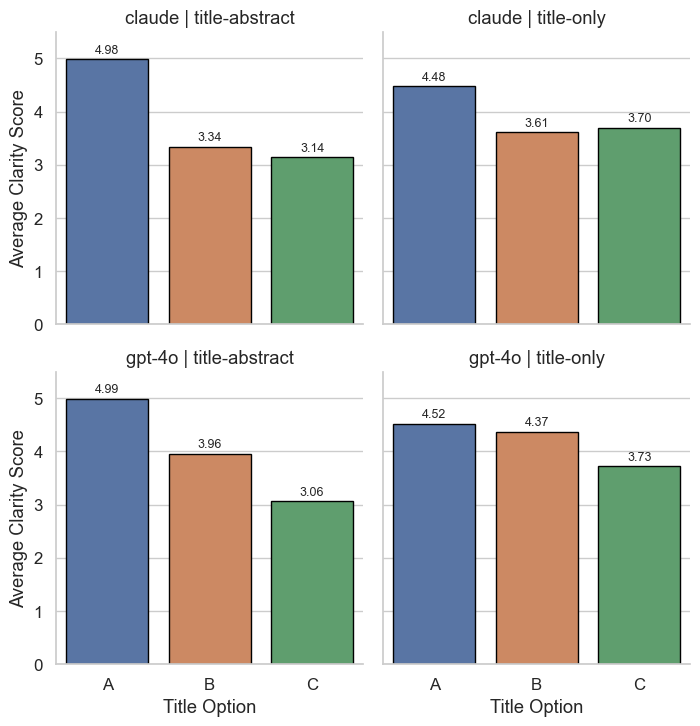

In [ ]:
df_all['mode_type'] = df_all['mode'].apply(
    lambda x: 'title-abstract' if 'abstract' in x else 'title-only'
)

metric_to_plot = 'clarity'

avg_df = (
    df_all
    .groupby(['mode_type','model','option'])[metric_to_plot]
    .mean()
    .reset_index()
)

sns.set_theme(style='whitegrid', font_scale=1.1)
palette = {'A': '#4C72B0', 'B': '#DD8452', 'C': '#55A868'}

g = sns.catplot(
    data=avg_df, kind='bar',
    x='option', y=metric_to_plot, hue='option',
    col='mode_type', row='model',
    palette=palette, ci=None,
    height=4, aspect=0.9, edgecolor='black'
)

for ax in g.axes.flatten():
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', fontsize=9, padding=2)

g.set_titles("{row_name} | {col_name}")
g.set_axis_labels("Title Option", f"Average {metric_to_plot.capitalize()} Score")
g.set(ylim=(0,5.5))

plt.subplots_adjust(top=0.88)

plt.show()


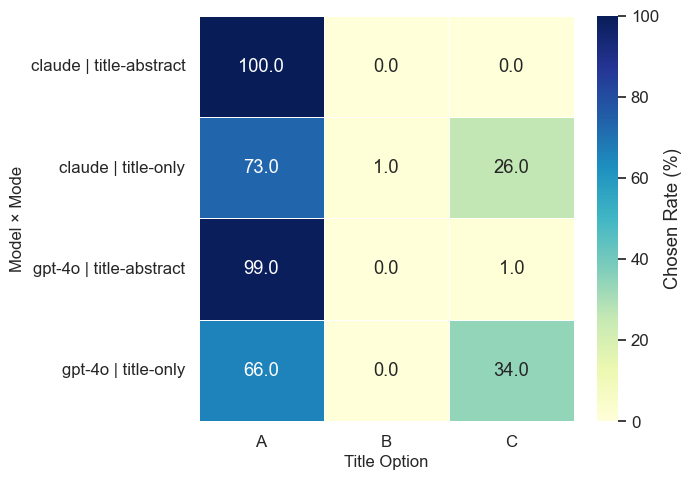

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

heat_df = (
    df_all.groupby(['model','mode','option'])['chosen']
    .mean()
    .reset_index()
)
heat_df['chosen_rate'] = heat_df['chosen'] * 100
heat_df['group'] = heat_df['model'] + ' | ' + heat_df['mode']

pivot_df = heat_df.pivot(index='group', columns='option', values='chosen_rate')

sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(7,5))
ax = sns.heatmap(
    pivot_df,
    annot=True, fmt=".1f", cmap="YlGnBu",
    cbar_kws={'label': 'Chosen Rate (%)'},
    linewidths=0.5, linecolor='white'
)

ax.set_xlabel("Title Option", fontsize=12)
ax.set_ylabel("Model × Mode", fontsize=12)

plt.tight_layout()
plt.show()


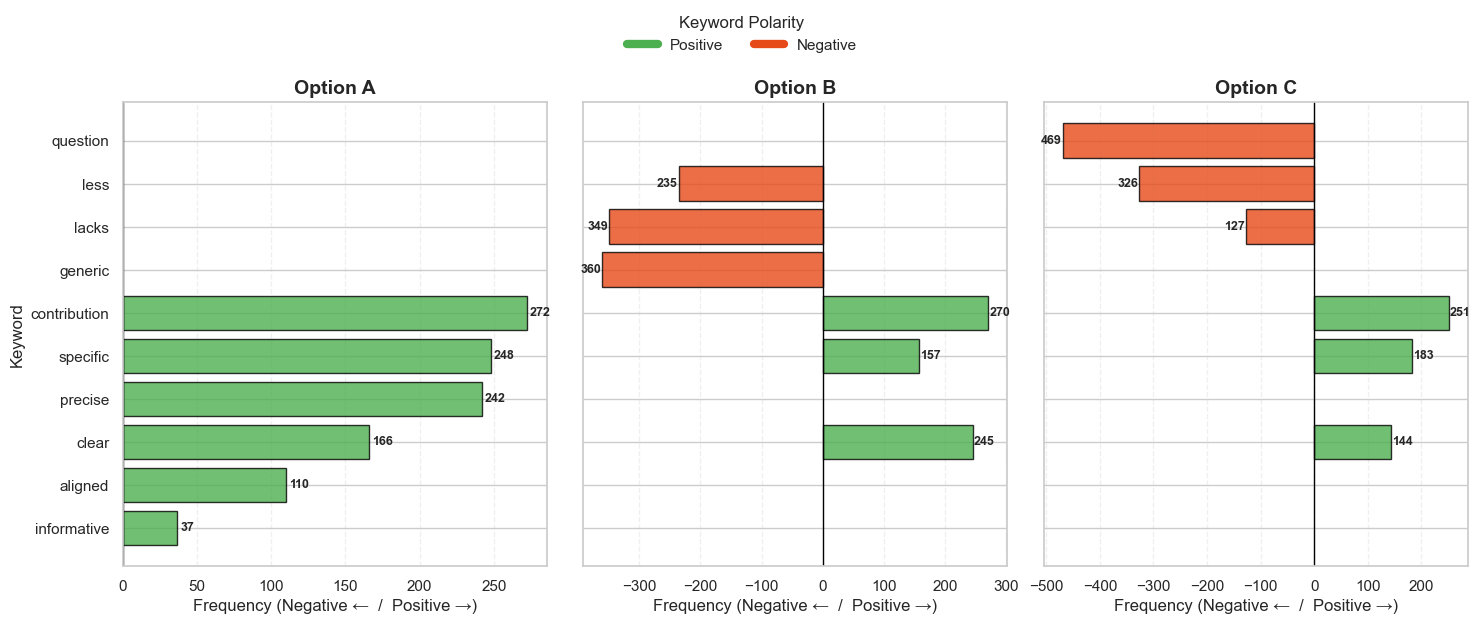

In [ ]:
# Diverging Bar Chart for Positive vs Negative Keywords

import json, re
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base = Path("../results")
domains = ["cv","nlp"]
models  = ["claude","gpt-4o"]
modes   = ["title-abstract","title-only"]

POSITIVE = {"precise","clear","specific","aligned","contribution","informative","accurate"}
NEGATIVE = {"generic","lacks","less","vague","misaligned","question","ambiguous","unclear","misleading"}

def tokenize(text):
    text = re.sub(r"[^a-zA-Z ]"," ",text).lower()
    return [w for w in text.split() if len(w) > 2]

token_counts = defaultdict(Counter)

for domain in domains:
    for model in models:
        for mode in modes:
            path = base / domain / f"{mode}_{model}_content.json"
            with open(path,"r",encoding="utf-8") as f:
                data = json.load(f)
            for d in data:
                if "reasons" not in d:
                    continue
                for opt in ["A","B","C"]:
                    if opt in d["reasons"]:
                        toks = tokenize(d["reasons"][opt])
                        for t in toks:
                            if t in POSITIVE or t in NEGATIVE:
                                token_counts[opt][t] += 1

records = []
for opt, counter in token_counts.items():
    for word, cnt in counter.items():
        polarity = "Positive" if word in POSITIVE else "Negative"
        value = cnt if polarity=="Positive" else -cnt
        records.append({"option": opt, "word": word, "value": value,
                        "count": cnt, "polarity": polarity})

df = pd.DataFrame(records)

df_top = (
    df.reindex(df['value'].abs().sort_values(ascending=False).index)
      .groupby("option")
      .head(6)
      .reset_index(drop=True)
)

sns.set_theme(style="whitegrid")
palette = {"Positive": "#4CAF50", "Negative": "#E64A19"}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=False, sharey=True)

for i, opt in enumerate(["A","B","C"]):
    ax = axes[i]
    subset = df_top[df_top["option"]==opt].sort_values("value")
    
    ax.barh(
        subset["word"],
        subset["value"],
        color=subset["polarity"].map(palette),
        alpha=0.8,
        edgecolor="black"
    )
    
    for _, row in subset.iterrows():
        ax.text(
            row["value"] + (2 if row["value"]>0 else -2),
            row["word"],
            f"{abs(row['count'])}",
            va="center",
            ha="left" if row["value"]>0 else "right",
            fontsize=9,
            weight="bold"
        )
    
    ax.axvline(0, color="black", linewidth=1)
    ax.set_title(f"Option {opt}", fontsize=14, weight="bold")
    ax.set_xlabel("Frequency (Negative ←  /  Positive →)")
    if i == 0:
        ax.set_ylabel("Keyword")
    else:
        ax.set_ylabel("")
    
    ax.grid(axis="x", linestyle="--", alpha=0.3)

handles = [
    plt.Line2D([0], [0], color=palette['Positive'], lw=6, label='Positive'),
    plt.Line2D([0], [0], color=palette['Negative'], lw=6, label='Negative')
]
fig.legend(handles=handles,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           ncol=2,
           frameon=False,
           fontsize=11,
           title="Keyword Polarity")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
